In [1]:
import datetime
import math
import time

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from hampel import hampel
from IPython.display import clear_output
from sklearn.metrics import mean_squared_error

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

/home/joaorobson/Documentos/TCC/experiments_notebooks/env/lib/python3.9/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
2021-11-02 12:32:49.914504: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-02 12:32:49.914529: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
df = pd.read_csv('medidas_04-05-2021/quarterly_measurements_CPD1.csv')
df['collection_date'] = pd.to_datetime(df['collection_date'], format='%Y-%m-%d %H:%M:%S')
df = df.sort_values('collection_date')
df

,id,collection_date,transductor_id,generated_energy_peak_time,generated_energy_off_peak_time,consumption_peak_time,consumption_off_peak_time,inductive_power_peak_time,inductive_power_off_peak_time,capacitive_power_peak_time,capacitive_power_off_peak_time,tax_id
0,1,2020-09-16 16:15:00,1,0.0,2236.937256,0.0,5788.039551,0.0,3774.395508,0.0,3343.380127,NaN
1,2,2020-09-16 16:15:00,1,0.0,2236.937256,0.0,5788.039551,0.0,3774.395508,0.0,3343.380127,NaN
2,3,2020-09-16 16:30:00,1,0.0,2251.918701,0.0,5816.766602,0.0,3787.614746,0.0,3350.856689,NaN
3,4,2020-09-16 16:45:00,1,0.0,2245.714600,0.0,5757.487793,0.0,3746.929932,0.0,3330.228760,NaN
4,5,2020-09-16 17:00:00,1,0.0,2212.775146,0.0,5719.126953,0.0,3702.991455,0.0,3304.887939,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
19370,113879,2021-05-04 07:30:00,1,0.0,1463.972778,0.0,4005.716553,0.0,2393.689453,0.0,2157.177002,NaN
19371,113880,2021-05-04 07:45:00,1,0.0,1453.804810,0.0,3977.073242,0.0,2424.012939,0.0,2201.976562,NaN
19372,113881,2021-05-04 08:00:00,1,0.0,1513.270142,0.0,4008.998291,0.0,2393.126221,0.0,2318.023926,NaN
19373,113882,2021-05-04 08:15:00,1,0.0,1528.613159,0.0,4209.576172,0.0,2475.284668,0.0,2283.731445,NaN


In [3]:
df.dtypes

id                                         int64
collection_date                   datetime64[ns]
transductor_id                             int64
generated_energy_peak_time               float64
generated_energy_off_peak_time           float64
consumption_peak_time                    float64
consumption_off_peak_time                float64
inductive_power_peak_time                float64
inductive_power_off_peak_time            float64
capacitive_power_peak_time               float64
capacitive_power_off_peak_time           float64
tax_id                                   float64
dtype: object

In [4]:
df['Consumo'] = df['generated_energy_peak_time'] + df['generated_energy_off_peak_time'] + df['consumption_peak_time'] + df['consumption_off_peak_time']

In [5]:
no_outliers_consumption = hampel(df['Consumo'], window_size=16, n=2, imputation=True)

In [6]:
df['no_outliers_consumption'] = no_outliers_consumption

In [7]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

data = df[['no_outliers_consumption']]
scaler.fit(data)
data = scaler.transform(data)
data = pd.DataFrame({'no_outliers_consumption': data.flatten()})

n = len(df)
train_df = data[0:int(n*0.7)][["no_outliers_consumption"]]
test_df = data[int(n*0.7):][["no_outliers_consumption"]]

In [ ]:
# import pickle
# pickle.dump(scaler, open('scaler.pk', 'wb'))

In [8]:
from keras.preprocessing.sequence import TimeseriesGenerator

look_back = 96

train_generator = TimeseriesGenerator(train_df['no_outliers_consumption'].values, train_df['no_outliers_consumption'].values, length=look_back, batch_size=1)     
test_generator = TimeseriesGenerator(test_df['no_outliers_consumption'].values, test_df['no_outliers_consumption'].values, length=look_back, batch_size=1)

In [9]:
X_train = np.array([data[0][0] for data in train_generator]).reshape((13466, 96, 1))
y_train = np.array([data[1] for data in train_generator]).reshape((13466, 1, 1))

X_test = np.array([data[0][0] for data in test_generator]).reshape((5717, 96, 1))
y_test = np.array([data[1] for data in test_generator]).reshape((5717, 1, 1))



In [10]:
MAX_EPOCHS = 15

# def compile_and_fit(model, window, patience=2):
# #   early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
# #                                                     patience=patience,
# #                                                     mode='min')
tf.keras.backend.clear_session()

model = tf.keras.Sequential([
    tf.keras.Input(shape=(96,1,), dtype='float32', name='input'),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(units=1)
])

model.compile(loss=tf.losses.MeanSquaredError(),
            optimizer=tf.optimizers.Adam(),
            metrics=[tf.metrics.MeanAbsoluteError()])

start = time.time()
history = model.fit(X_train, y_train, epochs=MAX_EPOCHS)
end = time.time()

2021-11-02 12:33:10.474089: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-11-02 12:33:10.474130: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-11-02 12:33:10.474150: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (joaorobson): /proc/driver/nvidia/version does not exist
2021-11-02 12:33:10.474405: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-02 12:33:11.341334: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Opt

Epoch 1/15
421/421 [==============================] - 104s 235ms/step - loss: 0.0035 - mean_absolute_error: 0.0290
Epoch 2/15
421/421 [==============================] - 101s 240ms/step - loss: 8.4003e-04 - mean_absolute_error: 0.0164
Epoch 3/15
421/421 [==============================] - 99s 236ms/step - loss: 7.4224e-04 - mean_absolute_error: 0.0160
Epoch 4/15
421/421 [==============================] - 99s 235ms/step - loss: 6.2220e-04 - mean_absolute_error: 0.0142
Epoch 5/15
421/421 [==============================] - 97s 230ms/step - loss: 5.6587e-04 - mean_absolute_error: 0.0137
Epoch 6/15
421/421 [==============================] - 112s 267ms/step - loss: 5.5622e-04 - mean_absolute_error: 0.0142
Epoch 7/15
421/421 [==============================] - 92s 220ms/step - loss: 5.1003e-04 - mean_absolute_error: 0.0137
Epoch 8/15
421/421 [==============================] - 88s 209ms/step - loss: 4.6218e-04 - mean_absolute_error: 0.0133
Epoch 9/15
421/421 [==============================] - 88s

In [11]:
print(f"Initial training time: {end-start} s")

Initial training time: 1509.4222087860107 s


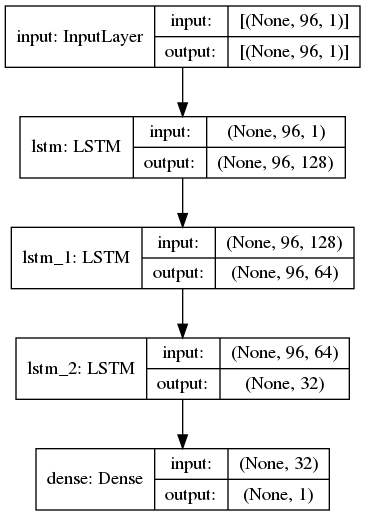

In [12]:
from keras.utils.vis_utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [13]:
preds = []
obs = []

In [14]:
start_forecasting = time.time()

for i in range(len(X_test)):
    if i < len(X_test) - 1:

        model.fit(X_test[i].reshape((1, 96, 1)), y_test[i].reshape((1, 1, 1)),
                 verbose=0 )

        output = model.predict(X_test[i+1].reshape((1,96,1)))

        preds.append(output[0][0])
        print(i)
        clear_output(wait=True)

end_forecasting = time.time()

5715


In [15]:
print(f"Rolling forecasting time: {end_forecasting-start_forecasting} s")
print(f"Total training time: {(end-start) + (end_forecasting-start_forecasting)} s")

Rolling forecasting time: 1383.3886077404022 s
Total training time: 2892.810816526413 s


In [16]:
_preds_inv = scaler.inverse_transform([preds])
obs_inv = scaler.inverse_transform([y_test.reshape((5717))])

In [17]:
size = len(df) - len(obs_inv[0]) + 1

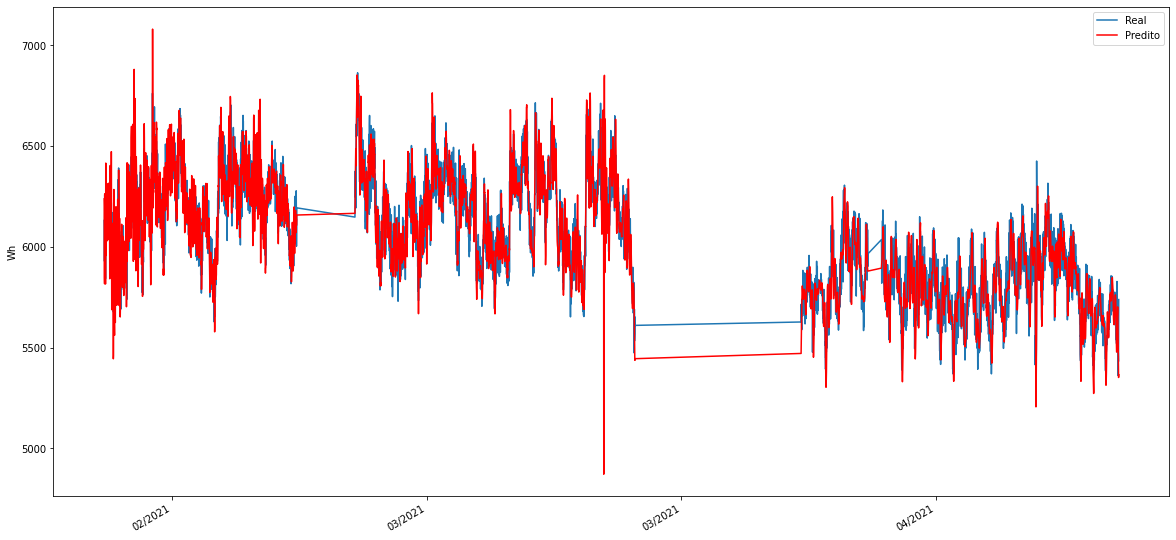

<Figure size 576x432 with 0 Axes>

In [18]:
import matplotlib.dates as mdates

plt.figure(figsize=(20,10))
plt.ylabel('Wh')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%Y'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=20))
plt.gcf().autofmt_xdate()

# plt.title('Predições para os próximos 15 min.')
plt.plot(df[size:].collection_date, obs_inv[0][:-1], label='Real')
plt.plot(df[size:].collection_date, _preds_inv[0], color='red', label='Predito')
plt.legend(loc="upper right")
plt.show()
plt.savefig('lstm.png')


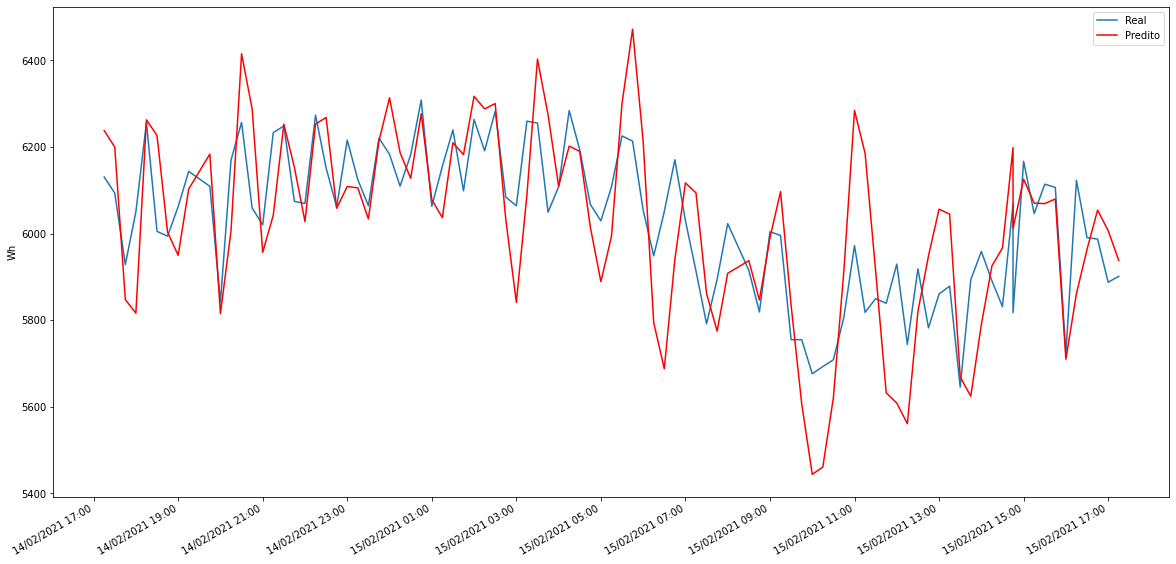

In [19]:

plt.figure(figsize=(20,10))
plt.ylabel('Wh')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%Y %H:%M'))
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval = 2))
plt.gcf().autofmt_xdate()


plt.plot(df[size + 96:size+96+96].collection_date, obs_inv[0][:96], label='Real')
plt.plot(df[size + 96:size+96+96].collection_date, _preds_inv[0][:96], color='red', label='Predito')
plt.legend(loc="upper right")
plt.show()

In [20]:
from sklearn.metrics import mean_absolute_error

print(mean_absolute_error(obs_inv[0][:-1], _preds_inv[0]))

88.15433389497022


In [21]:
model.save('model.json')

2021-11-02 13:21:33.453672: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: model.json/assets


INFO:tensorflow:Assets written to: model.json/assets
